In [ ]:
# Random forest
import json
import pandas as pd

# Load the dataset
with open(r"C:\Users\jayan\Downloads\MMHS150K\MMHS150K_GT.json", 'r') as file:
    data = json.load(file)


In [ ]:
# Convert to DataFrame
tweets_df = pd.DataFrame.from_dict(data, orient='index')
tweets_df.index = tweets_df.index.map(str) 

# Load splits
train_ids = pd.read_csv(r"C:\Users\jayan\Downloads\MMHS150K\splits\train_ids.txt", header=None,dtype=str).squeeze()
val_ids = pd.read_csv(r"C:\Users\jayan\Downloads\MMHS150K\splits\val_ids.txt", header=None,dtype=str).squeeze()
test_ids = pd.read_csv(r"C:\Users\jayan\Downloads\MMHS150K\splits\test_ids.txt", header=None,dtype=str).squeeze()

# Split the data
train_df = tweets_df.loc[train_ids]
val_df = tweets_df.loc[val_ids]
test_df = tweets_df.loc[test_ids]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=1000)
X_train = vectorizer.fit_transform(train_df['tweet_text'])
X_val = vectorizer.transform(val_df['tweet_text'])
X_test = vectorizer.transform(test_df['tweet_text'])

# Encode labels
# Assuming the majority label is chosen as the label for the tweet
y_train = train_df['labels'].apply(lambda x: max(set(x), key=x.count))
y_val = val_df['labels'].apply(lambda x: max(set(x), key=x.count))
y_test = test_df['labels'].apply(lambda x: max(set(x), key=x.count))

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train the classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predictions
y_pred_val = rf_classifier.predict(X_val)
y_pred_test = rf_classifier.predict(X_test)

# Evaluation
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Classification Report on Test Data:")
print(classification_report(y_test, y_pred_test)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import numpy as np
# Binarize the labels
y_bin = label_binarize(y_train, classes=np.unique(y_train))
n_classes = y_bin.shape[1]

# Fit a one-vs-rest classifier
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
y_score = clf.fit(X_train, y_bin).predict_proba(X_test)

# Binarize the labels for validation set
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves
plt.figure()

colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC')
plt.legend(loc="lower right")
plt.show()

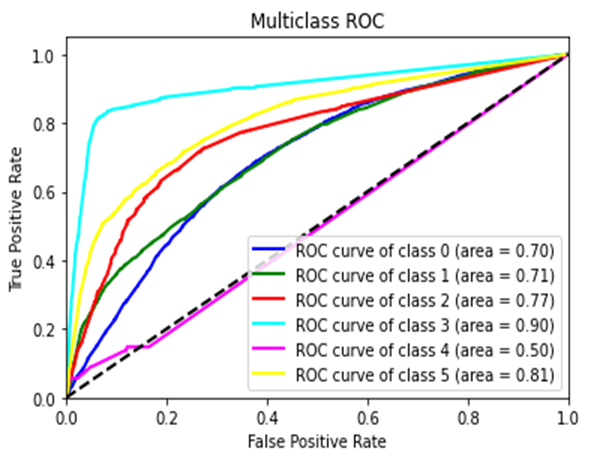

In [ ]:
# Define the re-encoding function
def reencode_labels(label):
    label_map = {0: 0, 1: 1, 2: 2, 3: 2, 4: 1, 5: 3}
    return label_map[label]

# Apply the re-encoding function
y_train_new = np.array([reencode_labels(label) for label in y_train])
y_val_new = np.array([reencode_labels(label) for label in y_val])
y_test_new = np.array([reencode_labels(label) for label in y_test])

In [ ]:
# Fit the label encoder on the new labels
vectorized_reencode = np.vectorize(reencode_labels)
y_train_new = vectorized_reencode(y_train)
y_val_new = vectorized_reencode(y_val)
y_test_new = vectorized_reencode(y_test)

# Train a new classifier with the updated labels
rf_classifier_new = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_new.fit(X_train, y_train_new)

# Predictions
y_pred_val_new = rf_classifier_new.predict(X_val)
y_pred_test_new = rf_classifier_new.predict(X_test)

# Evaluation
print("Validation Accuracy:", accuracy_score(y_val_new, y_pred_val_new))
print("Test Accuracy:", accuracy_score(y_test_new, y_pred_test_new))
print("Classification Report on Test Data:")
print(classification_report(y_test_new, y_pred_test_new))


In [ ]:
# Binarize the labels for the test set
y_test_bin_new = label_binarize(y_test_new, classes=np.unique(y_train_new))

# Compute ROC curve and ROC area for each new class
fpr_new = dict()
tpr_new = dict()
roc_auc_new = dict()
for i in range(n_classes_new):
    fpr_new[i], tpr_new[i], _ = roc_curve(y_test_bin_new[:, i], y_score_new[:, i])
    roc_auc_new[i] = auc(fpr_new[i], tpr_new[i])

# Plot the new ROC curves
plt.figure()
for i, color in zip(range(n_classes_new), colors[:n_classes_new]):  # Adjust color usage
    plt.plot(fpr_new[i], tpr_new[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc_new[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Adjusted Multiclass ROC for Combined Classes')
plt.legend(loc="lower right")
plt.show()

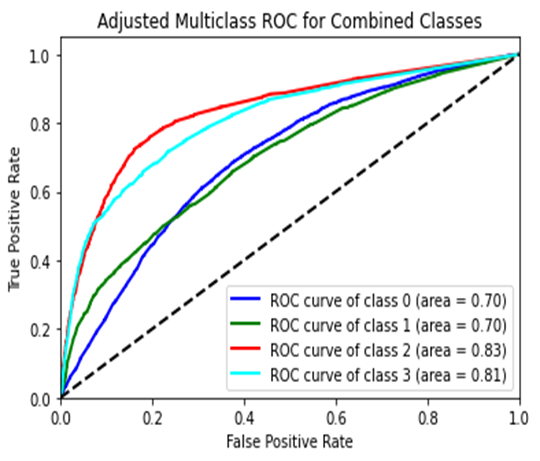

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming y_test_new and y_pred_test_new are your actual and predicted labels respectively
cm = confusion_matrix(y_test_new, y_pred_test_new)

# Normalize the confusion matrix by row (i.e., by the number of samples in each actual class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3], cbar=False)

plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

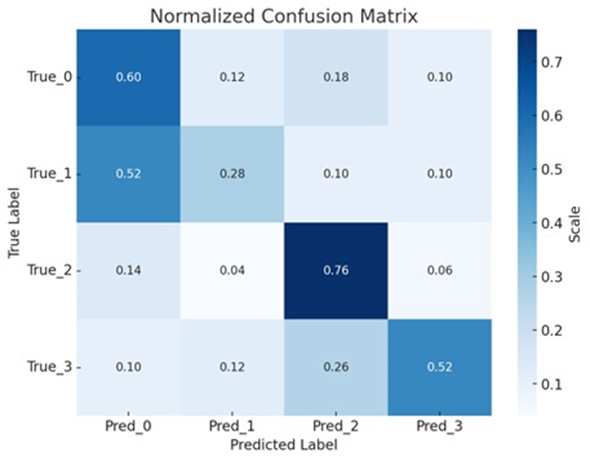